<img src=https://www.pngkit.com/png/full/861-8618685_numfocus-plotly-dash-logo.png alt="logo" width="400"/>

# Introduction

Dash is a library for creating interactive dashboards in python. The [documentation](https://dash.plotly.com/) is excellent, but examples can be a little verbose and hard to read. It is also designed to run as a server and to make the dashboards available via a web browser - this can be a little confusing at first.

To make life easier, we can use the newly-released jupyter-dash to see the figures within our notebook, and to slowly build up the complexity of our demos.

You can run this using Google Colab, but if you'd like to follow along make sure you install the necessary libraries with 
`conda install -c conda-forge -c plotly jupyter-dash` or `pip install jupyter-dash`.

To keep things moving swiftly, we'll use the data from Tuesday's deep learning demo. Skim past the setup and data sections and let's get plotting!

# Setup

In [ ]:
# Install the library we'll be using
!pip install jupyter-dash -q

# Getting the data

For this demonstration we'll load a public dataset from a study on Diabetes from the National Institute of Diabetes and Digestive and Kidney Diseases. You can read more about the data (including cariable descriptions and citations) [here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names). 

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/surabhim/Diabetes/master/Diabetes.csv', skiprows=9, 
                 names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']) # or read data/diabetes.csv from Tuesday
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


For some background, the columns definitions (from the original file):
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

Now, we could start exploring and plotting with seaborn or matplotlib, but that's not our goal today - let's see if we can make some interactive visuals!

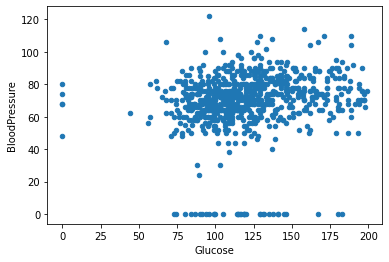

In [ ]:
# Look at this - it doesn't even move!
df.plot(kind='scatter', x='Glucose', y='BloodPressure')

# Our first figure

Let's try our first figure:

In [ ]:
# Import the necessary libraries:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

# If on Colab et al, run:
JupyterDash.infer_jupyter_proxy_config()

In [8]:
# Build the App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo 1 - Use HTML components!"),
    html.H2("Subheading Demo 1 - now with style!", style={'color':'green'}),
    dcc.Graph(id='graph1',
      figure=px.scatter(
          df, # Specify the dataframe
          x="BloodPressure", # Column for X axis...
          y="Glucose",
          title="BP vs Glucose",
          color='BMI' # We can add color (here showing BMI) or size to the points, as wqell as all sorts of other styling options
      )
    ),
])

# Run app and display result inline in the notebook
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

Pretty neat, right? Try zooming in, or hovering over specific data points.
But this is still a lot more trouble than seaborn/matplotlib/... Why exactly is this so great?

In [9]:
app.run_server(mode='external') # See it as it's own separate webpage!

Dash app running on:


<IPython.core.display.Javascript object>

Dash is designed to create interactive dashboards, not just to render static plots and display them in Jupyter. Behing the scenes it uses Flask, a web application framework. This means we can (quite) easily get our dash apps online to share with others! More on this later.

We can also use HTML components to arrange and style our dashboards. Notice the heading - html.H1 should ring a bell for anyone who has done web dev.

# Make it interactive!

We keep saying 'interactive'... is this just a fancy way of selling the fact that we can now zoom in to our plots? 

Not quite :) Dash uses something called 'Callbacks' to let different parts of our dashboard talk to eachother, enabling a lot more interaction.

In [10]:
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo 2 - Callbacks and interactivity"),
    dcc.Graph(id='graph1'), # We'll update the figure in the callback. The id is used to modify this component.
    html.Label([
        "X Axis",
        dcc.Dropdown(
            id='x-axis-dropdown', clearable=False,
            value='BloodPressure', options=[
                {'label': c, 'value': c}
                for c in df.columns
            ])
    ]),
])

# Callbacks!
# Define callback to update graph
@app.callback(
    Output('graph1', 'figure'), # What are we updating?
    [Input("x-axis-dropdown", "value")] # What triggers an update?
)
def update_figure(chosen_x): 
    figure=px.scatter(
          df, # Specify the dataframe
          x=chosen_x, # The argument is determined by the input(s) - the "value" of the dropdown will be passes as chosen_x
          y="BMI",
          title=chosen_x + " vs BMI"
      )
    return figure

# Run app and display result inline in the notebook
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

Now we're interactive! What's going on here?

The function `update_figure(chosen_x)` creates a figure with the chosen variable as the X axis and BMI on the y axis. We'd like to change the X axis with a dropdown (a standard html component)

Rather than having a loop continually checking the dropdown value, we trigger a callback when it's value changes.

When the callback is triggered by one of it's inputs changing, it modified the output - in this case, the figure attribute of our graph component. We can use this to modify our figures in response to user input, or to react to actions like hover, select etc in our plot.

# Callbacks 2: Getting Fancy with States

We can add multiple callbacks, and each can take one or more inputs. Callbacks can also receive 'states' to access any additional info they may need from other components. Take a look at the docs - pretty much anything can be used to trigger a callback!

This example is a modified version of the previous one, where we add a second input to our callback to modify the y axis. We also try out a State, and see how it's different from an input.

In [11]:
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo 2.1 - More Callbacks"),
    dcc.Graph(id='graph1'), # We'll update the figure in the callback. The id is used to modify this component.
    
    # Options for specifying ...
    html.Label([
        "X Axis",
        dcc.Dropdown(
            id='x-axis-dropdown', clearable=False,
            value='BloodPressure', options=[
                {'label': c, 'value': c}
                for c in df.columns
            ])
    ]),
    html.Label([
        "Y Axis",
        dcc.Dropdown(
            id='y-axis-dropdown', clearable=False,
            value='Glucose', options=[
                {'label': c, 'value': c}
                for c in df.columns
            ])
    ]),
    html.Label([
        "Colour By",
        dcc.Dropdown(
            id='color-dropdown', clearable=False,
            value='BMI', options=[
                {'label': c, 'value': c}
                for c in df.columns
            ])
    ]),
])

# Callbacks

# Define callback to update graph
@app.callback(
    Output('graph1', 'figure'), # What are we updating?
    [Input("x-axis-dropdown", "value"), Input("y-axis-dropdown", "value")], # What triggers an update?
    [State('color-dropdown', 'value')] # We could use an input instead. How does this affect behaviour?
)
def update_figure(chosen_x, chosen_y, color_by): 
    figure=px.scatter(
          df, # Specify the dataframe
          x=chosen_x, # The argument is determined by the input(s) - the "value" of the dropdown will be passes as chosen_x
          y=chosen_y,
          title=chosen_x + " vs " + chosen_y,
          color=color_by
      )
    return figure

# Run app and display result inline in the notebook
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# Multiple figures
There is no reason we can't make multiple figures and arrange them however we like. Here's an example:

In [12]:
# Build App
app = JupyterDash(__name__, external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])
app.layout = html.Div([
    html.H1("JupyterDash Demo 3 - Multiple Figures!"),
    html.Div(className="row", style={ 'width':'100%'}, children=[
        html.Div(
            dcc.Graph(id='graph2',
              figure=px.scatter(
                  df, # Specify the dataframe
                  x="SkinThickness", 
                  y="Insulin",
                  title="SkinThickness vs Insulin"
              ),
            ), style={'display': 'inline-block', 'width':'49%'} # We can use HTML/CSS styling)
        ),
        html.Div(
            dcc.Graph(id='graph3',
              figure=px.scatter(
                  df, # Specify the dataframe
                  x="SkinThickness", 
                  y="Glucose",
                  title="SkinThickness vs glucose"
              ),
            ), style={'display': 'inline-block', 'width':'49%'} # We can use HTML/CSS styling)
        ),
    ]),
    
    dcc.Graph(id='graph1',
      figure=px.box(
          df, # Specify the dataframe
          x="Outcome", 
          y="SkinThickness",
          title="Outcomes..."
      )
    ),
])

# Run app and display result inline in the notebook
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# Keeping Things Organised

Dash is very powerful, and it's easy to get started by copying code. However, as you start to add complexity, things can quickly get messy. Even our simple three-graph example above, at ~40 lines of code, is starting to look intimidating. Imagine what it'll look like when we add a few callbacks and some different style options for the user to play with!

If you're building anything serious in dash, do yourself a favour and 
- Comment your code well
- Spend time refactoring and making it neat
- Give everything clear names
- Create reuseable components where possible
- Keep the layout from getting cluttered - move as much as possible elsewhere.

Let's see a version of the above with a bit more organisation. Notice I'm starting from scratch here - you can re-start the notebook and run this on it's own. You'll see why very soon.

In [13]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd

# LOAD THE DATA
df = pd.read_csv('https://raw.githubusercontent.com/surabhim/Diabetes/master/Diabetes.csv', skiprows=9, 
                 names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])
# Data process

# DEFINE COMPONENTS

def scatterplot(id, x, y):
  return dcc.Graph(id=id,
              figure=px.scatter(
                  df,
                  x=x, 
                  y=y,
                  title=f"{x} vs {y}"
              ))

def boxplot(id, y):
  return dcc.Graph(id='graph1',
      figure=px.box(
          df, # Specify the dataframe
          x="Outcome", 
          y=y,
          title=f"Distributions of {y} for both outcomes"
      )
    )

# SPECIFY LAYOUT

app = JupyterDash(__name__, external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])
app.layout = html.Div([
    # Heading
    html.H1("JupyterDash Demo 3 - Multiple Figures!"),

    # First Row
    html.Div(className="row", style={ 'width':'100%'}, children=[
        # Two scatter plots
        html.Div(scatterplot('scatter_1', 'Glucose', 'BMI'), style={'display': 'inline-block', 'width':'33%'}),
        html.Div(scatterplot('scatter_2', 'SkinThickness', 'BMI'), style={'display': 'inline-block', 'width':'33%'}),
        # Box plot
        html.Div(boxplot('boxplot', 'BMI'), style={'display': 'inline-block', 'width':'33%'})
    ]),
])

# ADD CALLBACKS IF NEEDED
# ...

# RUN APP
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

# Breaking out of Jupyter

We can copy the code above into it's own file, replacing JupyterDash with standard dash. This can then be run locally for testing, or deployed to a hosting service with a little extra effort. 

In [14]:
# Demo Time!

# Exercises:

- Create some interactive plots with a different dataset
- Check out the dash app gallery 
- Write 'Dash exists' on a note to yourself, to reference next time you are working on a personal project that could use some pretty plots :)